# Comparing Centrality Metrics

This notebook analyzes and compares different centrality metrics for a citation network.

It loads node and edge data from JSON files, calculates various centrality metrics (like degree, betweenness, closeness etc.), and compares them against ground truth measures like importance and document type.

The notebook defines constants for:
- Input data file paths
- Centrality metrics to analyze 
- Ground truth measures to compare against

It also defines TypedDict classes to type the network statistics and results.

**Note:** This is an analysis notebook. To modify the code that generates the network and calculates centralities, please refer to the Main section.



In [337]:
import pandas as pd
import numpy as np
import networkx as nx
import datetime
import dateutil.parser
import statistics
from collections import defaultdict
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import spearmanr
import seaborn as sns
import os
import json
from typing import Dict, List, Union, TypedDict, Tuple


# Types

In [338]:
class NetworkStats(TypedDict):
    n_nodes: int
    n_edges: int

class BestCentralities(TypedDict):
    high: str
    low: str

class AnalysisResults(TypedDict):
    network_stats: NetworkStats
    correlations: Dict[str, Dict[str, Dict[tuple[str, str], float]]]  # ground_truth -> composite_function -> (centrality, ground_truth) -> correlation
    best_centralities: Dict[str, BestCentralities]  # ground_truth -> best centralities
    composite_rankings: Dict[str, Dict[str, Dict[str, float]]]  # ground_truth -> composite_function -> ecli -> rank
    dataframe: pd.DataFrame

# Utils

In [339]:
# Convert doctypebranch to a numeric value
def categorise_total_branch_numerically(branches: pd.Series) -> pd.Series:
    """
    Convert branch categorisation from strings into numbers.
    
    :param branches: The column containing branch data, categorized with strings.
    :return: A pandas Series with numerical categorization.
    """
    mapping = {
        "GRANDCHAMBER": 1,
        "CHAMBER": 2,
        "COMMITTEE": 3,
    }
    
    # Convert to uppercase to ensure consistent matching
    branches = branches.str.upper()
    
    # Print any values that don't match our mapping
    unmapped = set(branches.unique()) - set(mapping.keys())
    if unmapped:
        print(f"Warning: Found unmapped values: {unmapped}")
    
    return branches.map(mapping)

def prep_data(df: pd.DataFrame, include: list) -> pd.DataFrame:
    """
    Prepare the dataset by selecting the appropriate columns and filtering out rows with uncomputed metric values.
    
    :param df: The DataFrame to process.
    :param include: Columns to include.
    :return: The processed DataFrame.
    """
    headers = include + ['ecli']  # Ensure essential columns are included
    headers = list(set(headers))  # Removing duplicates

    data = df[headers]

    # Filter out rows with uncomputed metric values (-2)
    metric_column = include[-1]
    data = data[data[metric_column] >= -1]

    return data

# Centrality Calculation

In [340]:
def calculate_disruptions_new(graph: nx.Graph) -> dict:
    """
    Calculate the disruption score for each node in the graph.

    Args:
        graph (nx.Graph): The input directed graph.

    Returns:
        dict: A dictionary with nodes as keys and their disruption scores as values.
    """
    disruptions = {}
    for node in graph.nodes:
        i, j, k = 0, 0, 0

        # count j
        for in_node in graph.predecessors(node):
            for out_node in graph.successors(node):
                if graph.has_edge(in_node, out_node):
                    j += 1
                    break

        # count i
        i = graph.in_degree(node) - j

        # count k
        for out_node in graph.successors(node):
            for in_out_node in graph.predecessors(out_node):
                if in_out_node != node and not graph.has_edge(in_out_node, node):
                    k += 1

        try:
            disruptions[node] = (i - j) / (i + j + k)
        except ZeroDivisionError:
            disruptions[node] = np.nan

    return disruptions


# Function to calculate centrality measures
def calculate_centrality_measures(graph):
    """Calculate various centrality measures for the graph."""
    measures = {
        'degree_centrality': nx.degree_centrality(graph),
        'in_degree_centrality': nx.in_degree_centrality(graph),
        'out_degree_centrality': nx.out_degree_centrality(graph),
        'betweenness_centrality': nx.betweenness_centrality(graph),
        'closeness_centrality': nx.closeness_centrality(graph),
        'core_number': nx.core_number(graph),
        'relative_in_degree_centrality': {node: degree/len(graph) 
                                        for node, degree in graph.in_degree()},
        'harmonic_centrality': nx.harmonic_centrality(graph)
    }
    
    # Handle potentially failing measures with try-except
    try:
        measures['eigenvector_centrality'] = nx.eigenvector_centrality(graph, max_iter=1000)
    except (nx.PowerIterationFailedConvergence, nx.NetworkXError):
        # Fill with zeros if calculation fails
        measures['eigenvector_centrality'] = {node: 0.0 for node in graph.nodes()}
    
    try:
        measures['pagerank'] = nx.pagerank(graph)
    except:
        measures['pagerank'] = {node: 0.0 for node in graph.nodes()}
    
    try:
        hub_dict, authority_dict = nx.hits(graph)
        measures['hits_hub'] = hub_dict
        measures['hits_authority'] = authority_dict
    except:
        measures['hits_hub'] = {node: 0.0 for node in graph.nodes()}
        measures['hits_authority'] = {node: 0.0 for node in graph.nodes()}
    
    try:
        measures['disruption'] = calculate_disruptions_new(graph)
    except:
        measures['disruption'] = {node: 0.0 for node in graph.nodes()}
        
    return measures

# Composite Ranking

In [348]:
"""
This script analyzes the relationship between various centrality measures and ground truth scores
for legal cases. It aims to find the best centrality measures for predicting high and low relevance
scores, create a composite ranking, and evaluate its performance against individual centrality measures.

The main steps are:
1. Plot error bars for centrality measures vs. ground truth scores
2. Find the best centrality measures for predicting high and low scores
3. Create a composite ranking using the best measures
4. Calculate correlations between rankings and ground truth scores
5. Visualize and save the results
"""

def plot_error_bars(df, centrality, ground_truth):
    """
    Plot error bars for a given centrality measure against a ground truth score.

    Args:
    df (pd.DataFrame): The dataframe containing the data
    centrality (str): The name of the centrality measure column
    ground_truth (str): The name of the ground truth score column

    This function visualizes the relationship between a centrality measure and a ground truth score,
    showing the mean centrality value for each ground truth score category along with error bars
    representing the standard deviation.
    """
    # Prepare data
    include = [ground_truth, centrality]
    data = prep_data(df, include)

    x_header = centrality
    y_header = ground_truth
    x, y = list(data[x_header]), list(data[y_header])
    categories = list(set(y))
    categories.sort()
    num_categories, num_instances = len(categories), len(x)
    y_instances = [[] for _ in range(num_categories)]
    for category_no in range(num_categories):
        for instance_no in range(num_instances):
            if y[instance_no] == categories[category_no]:
                y_instances[category_no].append(x[instance_no])
    x = [statistics.mean(y_instances[category_no]) for category_no in range(num_categories)]
    y = categories

    # Draw graph
    plt.figure(figsize=(10, 6))
    title = f"{centrality.capitalize()} vs Average {y_header.capitalize()}"
    plt.suptitle(title, fontsize=22)
    plt.xlabel(f"{centrality.capitalize()}", fontsize=22)
    plt.ylabel(f"{y_header.capitalize()}", fontsize=22)
    plt.yticks(categories, fontsize=16)

    # Calculate error bars
    stds = [statistics.stdev(y_instances[category_no]) for category_no in range(num_categories)]
    plt.errorbar(x, y, xerr=stds, fmt='o')

    plt.show()

def find_best_centralities(df, centralities, ground_truth):
    """
    Find the best centrality measures for predicting high and low ground truth scores.
    TODO: Include considerations for multiple ground truth scores

    Args:
    df (pd.DataFrame): The dataframe containing the data
    centralities (list): List of centrality measure column names
    ground_truth (str): The name of the ground truth score column

    Returns:
    tuple: (best_high, best_low) - the names of the best centrality measures for high and low scores

    This function calculates the Spearman correlation between each centrality measure and the ground truth,
    using 1 - |correlation| as an error metric. The centrality with the lowest error is chosen as best_high,
    and the second-lowest (excluding best_high) is chosen as best_low.
    """

    # TODO For COURTBRANCH: When selecting the optimal metric for the lower class (less importance) we weight it against the middle class.

    errors = {}
    
    for centrality in centralities:
        # Calculate correlation across the full range
        corr, _ = stats.spearmanr(df[centrality], df[ground_truth])
        errors[centrality] = 1 - abs(corr)  # Use 1 - |correlation| as error
    
    best_high = min(errors, key=errors.get)
    
    # Remove the best_high centrality from consideration for best_low
    errors.pop(best_high, None)
    
    best_low = min(errors, key=errors.get)
    
    return best_high, best_low

def rank_cases(df, centrality):
    """
    Rank cases based on a given centrality measure.

    Args:
    df (pd.DataFrame): The dataframe containing the data
    centrality (str): The name of the centrality measure column

    Returns:
    pd.Series: A series of rankings for each case

    This function ranks the cases in descending order of the centrality measure,
    with the highest centrality receiving rank 1.
    """
    return df[centrality].rank(ascending=False)

def create_treashold_composite_ranking(df, high_centrality, low_centrality, ground_truth):
    """
    Create a composite ranking based on a threshold approach using two centrality measures.
    
    Args:
        df: DataFrame containing the centrality measures
        high_centrality: Centrality measure that performs best for high scores
        low_centrality: Centrality measure that performs best for low scores
        ground_truth: Name of the ground truth column
        
    Returns:
        Series containing the composite ranking
    """
    # Normalize both centrality measures to [0,1] range
    high_normalized = (df[high_centrality] - df[high_centrality].min()) / (df[high_centrality].max() - df[high_centrality].min())
    low_normalized = (df[low_centrality] - df[low_centrality].min()) / (df[low_centrality].max() - df[low_centrality].min())
    
    # Find optimal threshold by testing different values
    thresholds = np.linspace(0, 1, 100)
    best_correlation = -1
    optimal_threshold = 0
    
    for threshold in thresholds:
        # Create composite ranking using current threshold
        composite = np.where(
            high_normalized > threshold,
            high_normalized,  # Use high centrality measure
            low_normalized    # Use low centrality measure
        )
        
        # Calculate correlation with ground truth
        correlation = abs(spearmanr(composite, df[ground_truth])[0])
        
        # Update if better correlation found
        if correlation > best_correlation:
            best_correlation = correlation
            optimal_threshold = threshold
    
    # Create final composite ranking using optimal threshold
    final_composite = np.where(
        high_normalized > optimal_threshold,
        high_normalized,
        low_normalized
    )
    
    print(f"Optimal threshold found: {optimal_threshold:.6f}")
    return final_composite, optimal_threshold

def create_composite_ranking(df, high_centrality, low_centrality, weight):
    """
    Create a composite ranking using two centrality measures.
    The weight is the weight given to the high_centrality ranking (0-1), different from 0 and 1.

    Args:
    df (pd.DataFrame): The dataframe containing the data
    high_centrality (str): The name of the centrality measure best for high scores
    low_centrality (str): The name of the centrality measure best for low scores
    weight (float): The weight given to the high_centrality ranking (0-1)

    Returns:
    pd.Series: A series of composite rankings for each case

    This function creates a weighted average of the rankings from two centrality measures,
    allowing for a balance between predicting high and low ground truth scores.
    """
    high_ranks = rank_cases(df, high_centrality)
    low_ranks = rank_cases(df, low_centrality)
    return weight * high_ranks + (1 - weight) * low_ranks

def find_optimal_weight(df, high_centrality, low_centrality, ground_truth):
    """
    Find the optimal weight for creating a composite ranking. 
    The weight is the weight given to the high_centrality ranking (0-1), different from 0 and 1.
    Args:
    df (pd.DataFrame): The dataframe containing the data
    high_centrality (str): The name of the centrality measure best for high scores
    low_centrality (str): The name of the centrality measure best for low scores
    ground_truth (str): The name of the ground truth score column

    Returns:
    float: The optimal weight (0-1) for the high_centrality ranking

    This function tests different weights to find the one that produces the composite ranking
    with the highest correlation to the ground truth scores.
    """
    best_corr = -1
    best_weight = 0.5  # Initialize to middle value
    for weight in np.arange(0.01, 1.00, 0.01):  # Exclude 0 and 1
        composite = create_composite_ranking(df, high_centrality, low_centrality, weight)
        corr, _ = stats.spearmanr(composite, df[ground_truth])
        if abs(corr) > best_corr:
            best_corr = abs(corr)
            best_weight = weight
    return best_weight

def calculate_correlations(df, centralities, ground_truths, composite_ranking):
    """
    Calculate correlations between rankings and ground truth scores.

    Args:
    df (pd.DataFrame): The dataframe containing the data
    centralities (list): List of centrality measure column names
    ground_truths (list): List of ground truth score column names
    composite_ranking (str): The name of the composite ranking column

    Returns:
    dict: A dictionary of correlation coefficients

    This function calculates Spearman correlations between the rankings of each centrality measure
    (including the composite ranking) and each ground truth score.
    """
    correlations = {}
    
    for centrality in centralities:
        centrality_ranking = rank_cases(df, centrality)
        for ground_truth in ground_truths:
            # Check if arrays have variation before calculating correlation
            if df[centrality].nunique() > 1 and df[ground_truth].nunique() > 1:
                corr, _ = stats.spearmanr(centrality_ranking, df[ground_truth])
                correlations[(centrality, ground_truth)] = corr
            else:
                correlations[(centrality, ground_truth)] = np.nan
    
    for ground_truth in ground_truths:
        if df[composite_ranking].nunique() > 1 and df[ground_truth].nunique() > 1:
            corr, _ = stats.spearmanr(df[composite_ranking], df[ground_truth])
            correlations[('composite', ground_truth)] = corr
        else:
            correlations[('composite', ground_truth)] = np.nan
    
    return correlations

def plot_correlations(correlations, ground_truth, output_file, best_high, best_low, composite_param):
    """
    Plot correlations between rankings and ground truth scores.

    Args:
    correlations (dict): Dictionary of correlation coefficients
    ground_truth (str): The name of the current ground truth score
    output_file (str): The name of the output file for the plot
    best_high (str): The name of the best centrality for high scores
    best_low (str): The name of the best centrality for low scores

    This function creates a bar plot showing the correlations between each centrality measure
    (including the composite ranking) and the ground truth scores.
    """
    centralities = list(set([k[0] for k in correlations.keys() if k[0] != 'composite']))
    ground_truths = list(set([k[1] for k in correlations.keys()]))
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Add text to show which centralities were used for the composite ranking
    text = f"Composite: {best_high} (high) + {best_low} (low)"
    if composite_param is not None:
        text += f"\nComposite Param: {composite_param}"
    ax.text(0.02, 0.98, text,
            transform=ax.transAxes, ha='left', va='top', 
            bbox=dict(facecolor='white', edgecolor='gray', alpha=0.6))
    
    x = np.arange(len(ground_truths))
    width = 0.8 / (len(centralities) + 1)
    
    for i, centrality in enumerate(centralities + ['composite']):
        offset = width * i - 0.4 + width/2
        rects = ax.bar(x + offset, [correlations[(centrality, gt)] for gt in ground_truths], width, label=centrality)
    
    ax.set_ylabel('Correlation Coefficient')
    ax.set_title(f'Correlations between Rankings and Ground Truths (optimized for {ground_truth})')
    ax.set_xticks(x, ground_truths)
    ax.legend(loc='best')
    
    plt.tight_layout()
    plt.savefig(output_file)
    plt.close()

def plot_centrality_vs_ground_truth(df, centrality, ground_truths, output_path):
    """
    Plot centrality measure against ground truth metrics with error bars.
    
    Args:
        df (pd.DataFrame): DataFrame containing the data
        centrality (str): Name of the centrality measure to plot
        ground_truths (list): List of ground truth measures to compare against
        output_path (str): Path to save the output plots
    """
    for ground_truth in ground_truths:
        # Prepare data
        data = df[[ground_truth, centrality]].copy()
        data = data[data[centrality] != -2]  # Remove uncomputed values
        
        # Group by ground truth value and calculate statistics
        grouped_stats = data.groupby(ground_truth)[centrality].agg(['mean', 'std']).reset_index()
        
        # Create the plot
        plt.figure(figsize=(10, 6))
        
        # Plot points and error bars
        plt.errorbar(grouped_stats['mean'], 
                    grouped_stats[ground_truth],
                    xerr=grouped_stats['std'],
                    fmt='o',  # Changed from 'o-' to 'o' to remove connecting line
                    capsize=5,
                    capthick=1,
                    elinewidth=1,
                    markersize=8)
        
        # Customize the plot
        plt.title(f'{centrality} vs. Average {ground_truth}', fontsize=16)
        plt.xlabel(centrality.replace('_', ' ').title(), fontsize=16)
        plt.ylabel(ground_truth.replace('_', ' ').title(), fontsize=16)
        plt.yticks(grouped_stats[ground_truth], fontsize=16)
        
        # Add grid
        plt.grid(True, linestyle='--', alpha=0.7)
        
        # Adjust layout and save
        plt.tight_layout()
        plt.savefig(f'{output_path}/{centrality}_{ground_truth}_error_bars.png', 
                   bbox_inches='tight', 
                   dpi=300)
        plt.close()

def save_correlations_to_csv(correlations, ground_truth, output_file, best_high, best_low):
    """
    Save correlation results to a CSV file.

    Args:
    correlations (dict): Dictionary of correlation coefficients
    ground_truth (str): The name of the current ground truth score
    output_file (str): The name of the output CSV file
    best_high (str): The name of the best centrality for high scores
    best_low (str): The name of the best centrality for low scores

    This function saves the correlation results to a CSV file for further analysis or reporting.
    """
    df_correlations = pd.DataFrame(correlations.items(), columns=['Pair', 'Correlation'])
    df_correlations[['Centrality', 'Ground Truth']] = pd.DataFrame(df_correlations['Pair'].tolist(), index=df_correlations.index)
    df_correlations = df_correlations.drop('Pair', axis=1)
    df_correlations.to_csv(output_file, index=False)

# Analyze Network Function
> The `analyze_network()` function performs comprehensive network analysis using various centrality measures and composite rankings.

## Input Parameters

- `nodes_df`: Pandas DataFrame containing node information, including ground truth scores and node attributes
- `edges_df`: Pandas DataFrame containing edge information (connections between nodes)  
- `ground_truths`: List of column names in nodes_df that contain ground truth scores to analyze
- `centralities`: List of centrality measures to calculate (e.g. degree, betweenness, etc.)
- `composite_functions`: List of functions that combine multiple centrality measures into composite rankings
- `output_path`: Directory path where analysis outputs will be saved

## Processing Steps

1. Creates output directory if it doesn't exist
2. Makes a copy of the input nodes DataFrame
3. For each ground truth measure:
   - Calculates an inverted version (max value - original value)
   - Stores inverted versions with "_inverted" suffix
4. Cleans data by:
   - Dropping rows with missing ECLI identifiers
   - Converting doctypebranch to numeric values if present
5. Calculates centrality measures specified
6. Creates composite rankings using provided functions
7. Computes correlations between:
   - Individual centrality measures and ground truths
   - Composite rankings and ground truths

## Return Value

Returns an `AnalysisResults` dictionary containing:
- `network_stats`: Basic statistics about the network (nodes, edges, density etc.)
- `correlations`: Correlation coefficients between rankings and ground truths
- `best_centralities`: Best performing centrality measures for each ground truth
- `composite_rankings`: Results of composite ranking calculations
- `dataframe`: Final processed DataFrame with all measures included

## Output Files

Saves various analysis results to the specified output directory, including:
- Correlation plots
- CSV files with detailed results
- Network statistics


In [342]:
def analyze_network(nodes_df: pd.DataFrame, 
                edges_df: pd.DataFrame, 
                ground_truths: list, 
                centralities: list,
                composite_functions: list,
                output_path: str) -> AnalysisResults:
    """
    Analyze a network using various centrality measures and composite rankings.
    
    Args:
        nodes_df: DataFrame containing node information
        edges_df: DataFrame containing edge information
        ground_truths: List of ground truth column names to analyze
        centralities: List of centrality measures to calculate
        composite_functions: List of composite ranking functions to use
        output_path: Path where to save output files
        
    Returns:
        dict: Dictionary containing:
        - 'network_stats': Dict with network statistics (nodes, edges, density)
        - 'correlations': Dict mapping ground truth names to correlation results
        - 'best_centralities': Dict mapping ground truth names to their best centrality measures
        - 'composite_rankings': Dict mapping composite function names to their results
        - 'dataframe': pandas DataFrame with all calculated measures and rankings
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_path, exist_ok=True)
    
    # Make a copy of nodes dataframe
    total_df = nodes_df.copy()

    # Convert doctypebranch to numeric if it exists
    if 'doctypebranch' in total_df.columns:
        total_df['doctypebranch'] = categorise_total_branch_numerically(total_df['doctypebranch'])
        # Remove rows with Nan doctypebranch
        total_df = total_df.dropna(subset=['doctypebranch'])

    # Convert ground truth columns to numeric
    for truth in ground_truths:
        total_df[truth] = pd.to_numeric(total_df[truth], errors='coerce')
    
    # Invert ground truth values
    ground_truths_inverted = []
    for truth in ground_truths:
        max_value = total_df[truth].max()
        inverted_col = f'{truth}_inverted'
        total_df[inverted_col] = max_value - total_df[truth]
        ground_truths_inverted.append(inverted_col)
    
    # Drop rows with missing ecli
    total_df = total_df.dropna(subset=['ecli'])
    
    # Create graph
    G = nx.DiGraph()
    
    # Add nodes with attributes
    for idx, row in total_df.iterrows():
        node_attrs = {truth: row[truth] for truth in ground_truths if truth in row}
        G.add_node(row['ecli'], **node_attrs)
    
    # Add edges between existing nodes
    valid_nodes = set(total_df['ecli'].values)
    for idx, row in edges_df.iterrows():
        source = row['ecli']
        targets = row['references']
        if source in valid_nodes:
            for target in targets:
                if target and target in valid_nodes:
                    G.add_edge(source, target)
    
    # Remove self-loops
    G.remove_edges_from(nx.selfloop_edges(G))
    
    # Calculate centrality measures
    centrality_measures = calculate_centrality_measures(G)
    centrality_df = pd.DataFrame(centrality_measures)
    
    # Merge centrality measures with total_df
    total_df = pd.merge(total_df, centrality_df, left_on='ecli', right_index=True, how='left')
    
    # Plot initial correlations
    numeric_cols = total_df.select_dtypes(include=[float, int]).columns
    for centrality in centralities:
        if centrality in numeric_cols:
            plot_centrality_vs_ground_truth(total_df, centrality, ground_truths, output_path)
    
    # Run composite rankings analysis and prepare results structure
    results = {
        'network_stats': {
            'n_nodes': len(total_df),
            'n_edges': len(edges_df)
        },
        'correlations': {},
        'best_centralities': {},
        'composite_rankings': {},
        'dataframe': total_df
    }

    # Initialize result dictionaries for each ground truth
    for ground_truth in ground_truths:
        results['correlations'][ground_truth] = {}
        results['best_centralities'][ground_truth] = {}
        results['composite_rankings'][ground_truth] = {}
        
        # Find best centralities once per ground truth
        best_high, best_low = find_best_centralities(total_df, centralities, ground_truth)
        results['best_centralities'][ground_truth] = {
            'high': best_high,
            'low': best_low
        }
        # Log the best centralities found for this ground truth
        print(f"\nBest centralities for {ground_truth}:")
        print(f"Best high correlation: {best_high}")
        print(f"Best low correlation: {best_low}")
        
        # Process each composite function
        for composite_function in composite_functions:
            print(f"\nAnalyzing ground truth: {ground_truth} with {composite_function}")
            
            # Create composite ranking based on function type
            if composite_function == 'weight_composite_ranking':
                optimal_weight = find_optimal_weight(total_df, best_high, best_low, ground_truth)
                composite_ranking = create_composite_ranking(total_df, best_high, best_low, optimal_weight)
                results['composite_rankings'][ground_truth][f'{composite_function}_param'] = optimal_weight
            else:
                composite_ranking, threshold = create_treashold_composite_ranking(total_df, best_high, best_low, ground_truth)
                results['composite_rankings'][ground_truth][f'{composite_function}_param'] = threshold

            # Add composite ranking to dataframe
            ranking_col = f'composite_ranking_{ground_truth}_{composite_function}'
            total_df[ranking_col] = composite_ranking
            
            # Calculate correlations once and store them
            correlations = calculate_correlations(total_df, centralities, ground_truths, ranking_col)
            results['correlations'][ground_truth][composite_function] = correlations
            
            # Store composite rankings
            results['composite_rankings'][ground_truth][composite_function] = total_df[ranking_col].to_dict()
            
            # TODO Save visualization outputs
            plot_correlations(
                correlations, 
                ground_truth, 
                f'{output_path}/correlations_plot_{ground_truth}_{composite_function}.png',
                best_high, 
                best_low, 
                results['composite_rankings'][ground_truth][f'{composite_function}_param'],
            )
            
            save_correlations_to_csv(
                correlations,
                ground_truth,
                f'{output_path}/correlations_{ground_truth}_{composite_function}.csv',
                best_high,
                best_low
            )

    return results

# Compare Function
This section implements network comparison functionality to analyze and compare results across different networks.

The main function `compare_networks()` takes results from multiple network analyses and performs the following comparisons:

1. Correlation Comparisons:
   - Compares how different centrality measures correlate with ground truth metrics across networks
   - Creates comparison tables showing correlation values for each network
   - Saves correlation comparisons to CSV files

2. Ranking Comparisons: 
   - Analyzes how centrality measures rank relative to each other in different networks
   - Converts absolute correlation values to rankings
   - Shows which centrality measures perform consistently well across networks
   - Saves ranking comparisons to CSV files

The comparisons are performed for each combination of:
- Ground truth metrics (e.g., PageRank, degree centrality)
- Composite ranking functions (different ways of combining centrality measures)

This allows us to:
- Identify which centrality measures work best across different network types
- Understand how network structure affects centrality measure performance
- Compare the effectiveness of different composite ranking approaches


In [343]:
def compare_networks(network_results: Dict[str, AnalysisResults], output_path: str) -> Dict:
    """
    Compare centrality measure performance across different networks.
    
    Args:
        network_results: Dictionary mapping network names to their analysis results
        output_path: Path to save comparison results
    
    Returns:
        Dictionary containing aggregated analysis results per ground truth
    """
    os.makedirs(output_path, exist_ok=True)
    
    # Get ground truths from first network
    first_network = list(network_results.values())[0]
    ground_truths = list(first_network['correlations'].keys())
    
    analysis = {gt: {
        'centrality_counts': {
            'high': defaultdict(int),      # Times selected as best high
            'low': defaultdict(int),       # Times selected as best low
            'best_overall': defaultdict(int)  # Times had best correlation
        },
        'combination_counts': defaultdict(int),  # Times each high+low pair was selected
        'composite_performance': {
            'outperformed_count': 0,  # Times composite ranking beat individual centralities
            'best_combinations': []    # Combinations that achieved best performance
        }
    } for gt in ground_truths}
    
    # Analyze each network's results
    for network_name, results in network_results.items():
        for ground_truth in ground_truths:
            # Get best centralities selected for this network
            best_centralities = results['best_centralities'][ground_truth]
            best_high = best_centralities['high']
            best_low = best_centralities['low']
            
            # Count individual centrality selections
            analysis[ground_truth]['centrality_counts']['high'][best_high] += 1
            analysis[ground_truth]['centrality_counts']['low'][best_low] += 1
            
            # Count combination selections
            combination = f"{best_high}+{best_low}"
            analysis[ground_truth]['combination_counts'][combination] += 1
            
            # Find best overall centrality (highest correlation)
            correlations = results['correlations'][ground_truth]
            for composite_func, corr_dict in correlations.items():
                # Get correlation values for individual centralities
                centrality_correlations = {
                    cent: abs(corr) 
                    for (cent, gt), corr in corr_dict.items() 
                    if cent != 'composite'
                }
                
                # Find best performing centrality
                best_centrality = max(centrality_correlations.items(), key=lambda x: x[1])[0]
                analysis[ground_truth]['centrality_counts']['best_overall'][best_centrality] += 1
                
                # Check if composite ranking outperformed individual centralities
                composite_corr = abs(corr_dict[('composite', ground_truth)])
                if composite_corr > max(centrality_correlations.values()):
                    analysis[ground_truth]['composite_performance']['outperformed_count'] += 1
                    analysis[ground_truth]['composite_performance']['best_combinations'].append({
                        'network': network_name,
                        'combination': combination,
                        'correlation': composite_corr
                    })
    
    # Save results
    for ground_truth in ground_truths:
        results_file = f'{output_path}/network_analysis_{ground_truth}.json'
        with open(results_file, 'w') as f:
            json.dump(analysis[ground_truth], f, indent=4)
        
        # Create summary DataFrames
        centrality_summary = pd.DataFrame([{
            'centrality': cent,
            'times_best_high': analysis[ground_truth]['centrality_counts']['high'][cent],
            'times_best_low': analysis[ground_truth]['centrality_counts']['low'][cent],
            'times_best_overall': analysis[ground_truth]['centrality_counts']['best_overall'][cent]
        } for cent in set(
            list(analysis[ground_truth]['centrality_counts']['high'].keys()) +
            list(analysis[ground_truth]['centrality_counts']['low'].keys()) +
            list(analysis[ground_truth]['centrality_counts']['best_overall'].keys())
        )])
        
        centrality_summary.to_csv(
            f'{output_path}/centrality_summary_{ground_truth}.csv', 
            index=False
        )
        
        # Combination summary
        combination_summary = pd.DataFrame([{
            'combination': comb,
            'times_selected': count
        } for comb, count in analysis[ground_truth]['combination_counts'].items()])
        
        combination_summary.to_csv(
            f'{output_path}/combination_summary_{ground_truth}.csv',
            index=False
        )
    
    return analysis

# Data Visualization

In [344]:
def visualize_network_commonalities(analysis_results: Dict, output_path: str):
    """
    Visualize commonalities between networks focusing on centrality performance.
    
    Args:
        analysis_results: Dictionary containing the analysis results from compare_networks()
        output_path: Path to save visualization outputs
    """
    # Set the aesthetic style
    plt.style.use('default')
    
    # Create figure with five subplots (3x2 grid, with the last spot empty for summary)
    fig = plt.figure(figsize=(20, 25))
    gs = plt.GridSpec(3, 2, figure=fig)
    ax1 = fig.add_subplot(gs[0, 0])  # High performers
    ax2 = fig.add_subplot(gs[0, 1])  # Low performers
    ax3 = fig.add_subplot(gs[1, 0])  # Best overall performers
    ax4 = fig.add_subplot(gs[1, 1])  # Composite performance
    ax5 = fig.add_subplot(gs[2, 0])  # Total best occurrences
    
    # Colors for different ground truths
    colors = {'importance': 'skyblue', 'doctypebranch': 'lightgreen'}
    
    # 1. High Importance Performers Graph
    for ground_truth in analysis_results:
        high_counts = analysis_results[ground_truth]['centrality_counts']['high']
        if high_counts:
            centralities = list(high_counts.keys())
            counts = list(high_counts.values())
            ax1.bar(centralities, counts, label=ground_truth, alpha=0.7, color=colors[ground_truth])
    
    ax1.set_ylabel('Times Selected as Best High Predictor')
    ax1.set_title('Best Performing Centralities for High Scores')
    ax1.tick_params(axis='x', rotation=45)
    ax1.set_xticklabels(ax1.get_xticklabels(), ha='right')
    ax1.legend()
    
    # 2. Low Importance Performers Graph
    for ground_truth in analysis_results:
        low_counts = analysis_results[ground_truth]['centrality_counts']['low']
        if low_counts:
            centralities = list(low_counts.keys())
            counts = list(low_counts.values())
            ax2.bar(centralities, counts, label=ground_truth, alpha=0.7, color=colors[ground_truth])
    
    ax2.set_ylabel('Times Selected as Best Low Predictor')
    ax2.set_title('Best Performing Centralities for Low Scores')
    ax2.tick_params(axis='x', rotation=45)
    ax2.set_xticklabels(ax2.get_xticklabels(), ha='right')
    ax2.legend()
    
    # 3. Best Overall Performers Graph
    for ground_truth in analysis_results:
        best_overall = analysis_results[ground_truth]['centrality_counts']['best_overall']
        if best_overall:
            centralities = list(best_overall.keys())
            counts = list(best_overall.values())
            ax3.bar(centralities, counts, label=ground_truth, alpha=0.7, color=colors[ground_truth])
    
    ax3.set_ylabel('Times Selected as Best Overall')
    ax3.set_title('Best Overall Performing Centralities')
    ax3.tick_params(axis='x', rotation=45)
    ax3.set_xticklabels(ax3.get_xticklabels(), ha='right')
    ax3.legend()
    
    # 4. Combination Performance Graph
    for ground_truth in analysis_results:
        combinations = analysis_results[ground_truth]['combination_counts']
        if combinations:
            combo_names = list(combinations.keys())
            combo_counts = list(combinations.values())
            ax4.bar(combo_names, combo_counts, label=ground_truth, alpha=0.7, color=colors[ground_truth])
    
    ax4.set_ylabel('Times Selected as Best Combination')
    ax4.set_title('Best Performing Centrality Combinations')
    ax4.tick_params(axis='x', rotation=45)
    ax4.set_xticklabels(ax4.get_xticklabels(), ha='right')
    ax4.legend()
    
    # 5. Total Best Occurrences Graph
    # Combine counts across all categories and ground truths
    total_counts = {}
    for ground_truth in analysis_results:
        for category in ['high', 'low', 'best_overall']:
            counts = analysis_results[ground_truth]['centrality_counts'][category]
            for centrality, count in counts.items():
                if centrality not in total_counts:
                    total_counts[centrality] = 0
                total_counts[centrality] += count
    
    # Plot total counts
    if total_counts:
        centralities = list(total_counts.keys())
        counts = list(total_counts.values())
        ax5.bar(centralities, counts, color='lightcoral', alpha=0.7)
    
    ax5.set_ylabel('Total Times Selected as Best')
    ax5.set_title('Overall Best Performing Centralities (All Categories)')
    ax5.tick_params(axis='x', rotation=45)
    ax5.set_xticklabels(ax5.get_xticklabels(), ha='right')
    
    # Add a text box with summary statistics in the empty space (bottom right)
    summary_text = ""
    for ground_truth in analysis_results:
        summary_text += f"\n{ground_truth.upper()} SUMMARY:\n"
        # Most common high performer
        high_counts = analysis_results[ground_truth]['centrality_counts']['high']
        if high_counts:
            best_high = max(high_counts.items(), key=lambda x: x[1])
            summary_text += f"Best High: {best_high[0]} ({best_high[1]} times)\n"
        
        # Most common low performer
        low_counts = analysis_results[ground_truth]['centrality_counts']['low']
        if low_counts:
            best_low = max(low_counts.items(), key=lambda x: x[1])
            summary_text += f"Best Low: {best_low[0]} ({best_low[1]} times)\n"
        
        # Most common combination
        combinations = analysis_results[ground_truth]['combination_counts']
        if combinations:
            best_combo = max(combinations.items(), key=lambda x: x[1])
            summary_text += f"Best Combination: {best_combo[0]} ({best_combo[1]} times)\n"
        
        # Add outperformance statistics
        outperformed_count = analysis_results[ground_truth]['composite_performance']['outperformed_count']
        best_combinations = analysis_results[ground_truth]['composite_performance']['best_combinations']
        summary_text += f"Times composites outperformed: {outperformed_count}\n"
        
        if best_combinations:
            # Count occurrences of each combination that outperformed
            combo_counts = {}
            for entry in best_combinations:
                combo = entry['combination']
                combo_counts[combo] = combo_counts.get(combo, 0) + 1
            
            # Get the combination that outperformed most often
            best_outperforming = max(combo_counts.items(), key=lambda x: x[1])
            summary_text += f"Best outperforming combo: {best_outperforming[0]} ({best_outperforming[1]} times)\n"
            
            # Add the highest correlation achieved
            best_correlation = max(entry['correlation'] for entry in best_combinations)
            summary_text += f"Highest correlation achieved: {best_correlation:.3f}\n"
    
    # Add overall best performer from total counts
    if total_counts:
        best_overall = max(total_counts.items(), key=lambda x: x[1])
        summary_text += f"\nOVERALL BEST PERFORMER:\n{best_overall[0]} (Selected {best_overall[1]} times total)"
    
    # Add text box to figure in bottom right
    plt.figtext(0.65, 0.15, summary_text, fontsize=10, 
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))
    
    # Adjust layout and save
    plt.tight_layout()
    plt.savefig(f'{output_path}/network_performance_analysis.png', 
                bbox_inches='tight', dpi=300)
    plt.close()
    
    # Save detailed numerical results
    summary = {
        ground_truth: {
            'high_performers': dict(analysis_results[ground_truth]['centrality_counts']['high']),
            'low_performers': dict(analysis_results[ground_truth]['centrality_counts']['low']),
            'best_overall': dict(analysis_results[ground_truth]['centrality_counts']['best_overall']),
            'combinations': dict(analysis_results[ground_truth]['combination_counts']),
            'composite_performance': {
                'outperformed_count': analysis_results[ground_truth]['composite_performance']['outperformed_count'],
                'best_combinations': analysis_results[ground_truth]['composite_performance']['best_combinations']
            },
            'best_performers': {
                'high': max(analysis_results[ground_truth]['centrality_counts']['high'].items(), 
                           key=lambda x: x[1])[0] if analysis_results[ground_truth]['centrality_counts']['high'] else None,
                'low': max(analysis_results[ground_truth]['centrality_counts']['low'].items(), 
                          key=lambda x: x[1])[0] if analysis_results[ground_truth]['centrality_counts']['low'] else None,
                'overall': max(analysis_results[ground_truth]['centrality_counts']['best_overall'].items(), 
                             key=lambda x: x[1])[0] if analysis_results[ground_truth]['centrality_counts']['best_overall'] else None,
                'combination': max(analysis_results[ground_truth]['combination_counts'].items(), 
                                 key=lambda x: x[1])[0] if analysis_results[ground_truth]['combination_counts'] else None
            }
        }
        for ground_truth in analysis_results
    }
    
    # Add total counts to summary
    summary['total_counts'] = total_counts
    
    with open(f'{output_path}/visualization_summary.json', 'w') as f:
        json.dump(summary, f, indent=4)

# Load Networks

In [345]:
def load_networks(path, max=100):
    """
    Load networks from a directory structure, handling nested directories.
    Networks must be in their own folder containing only nodes.json and edges.json files.
    
    Args:
        path: Root directory to search for networks
        max: Maximum number of networks to load
    
    Returns:
        dict: Dictionary of networks with structure {network_name: {'nodes': df, 'edges': df}}
    """
    networks = {}
    loaded_count = 0
    
    # Verify root directory exists and print absolute path
    abs_root = os.path.abspath(path)
    print(f"Looking for networks in: {abs_root}")
    
    if not os.path.exists(abs_root):
        raise ValueError(f"Directory {abs_root} does not exist")
        
    def is_network_dir(dir_path):
        """Check if directory contains exactly one nodes.json and one edges.json"""
        contents = os.listdir(dir_path)
        return (len(contents) == 2 and 
                'nodes.json' in contents and 
                'edges.json' in contents)
    
    def process_directory(current_path, parent_prefix=""):
        nonlocal loaded_count
        if loaded_count >= max:
            return
            
        for item in os.listdir(current_path):
            if loaded_count >= max:
                break
                
            item_path = os.path.join(current_path, item)
            if not os.path.isdir(item_path):
                continue
                
            # Check if current directory is a network directory
            if is_network_dir(item_path):
                # Generate network name based on path
                rel_path = os.path.relpath(item_path, abs_root)
                network_name = rel_path.replace(os.sep, '-')
                
                print(f"\nChecking network: {network_name}")
                print(f"  Path: {item_path}")
                
                nodes_file = os.path.join(item_path, 'nodes.json')
                edges_file = os.path.join(item_path, 'edges.json')
                
                try:
                    # Load and validate data
                    print("  Loading data files...")
                    nodes_df = pd.read_json(nodes_file)
                    edges_df = pd.read_json(edges_file)
                    
                    # Validate required columns
                    required_node_cols = ['ecli', 'importance', 'doctypebranch']
                    missing_cols = [col for col in required_node_cols if col not in nodes_df.columns]
                    if missing_cols:
                        print(f"  Warning: Missing columns in nodes.json: {missing_cols}")
                        print(f"  Available columns: {nodes_df.columns.tolist()}")
                        continue
                    
                    required_edge_cols = ['ecli', 'references']
                    missing_edge_cols = [col for col in required_edge_cols if col not in edges_df.columns]
                    if missing_edge_cols:
                        print(f"  Warning: Missing columns in edges.json: {missing_edge_cols}")
                        print(f"  Available columns: {edges_df.columns.tolist()}")
                        continue
                    
                    networks[network_name] = {
                        'nodes': nodes_df,
                        'edges': edges_df
                    }
                    loaded_count += 1
                    print(f"  Successfully loaded network with {len(nodes_df)} nodes and {len(edges_df)} edges")
                    
                except Exception as e:
                    print(f"  Error loading network: {str(e)}")
                    continue
            else:
                # Recursively process subdirectories
                process_directory(item_path)
    
    # Start processing from root directory
    process_directory(abs_root)
    print(f"\nSuccessfully loaded {len(networks)} networks")
    return networks

# Main

In [346]:
# Centralities of interest
CENTRALITIES = ['degree_centrality', 'in_degree_centrality', 'out_degree_centrality', 
                'betweenness_centrality', 'closeness_centrality', 'core_number', 
                'relative_in_degree_centrality', 'eigenvector_centrality', 
                'pagerank', 'hits_hub', 'hits_authority', 'harmonic_centrality', 'disruption']

# Ground truths of interest
GROUND_TRUTHS = ['importance', 'doctypebranch']
GROUND_TRUTHS_INVERTED = ['importance_inverted',  'doctypebranch_inverted']

In [ ]:
# # Load all networks from data/split directory
# network_results = {}

# networks = load_networks('networks')

# # Analyze Networks
# for network_name, data in networks.items():
#     print(f"\nAnalyzing network: {network_name}")
#     results = analyze_network(
#         nodes_df=data['nodes'],
#         edges_df=data['edges'],
#         ground_truths=GROUND_TRUTHS,
#         centralities=CENTRALITIES,
#         composite_functions=['weight_composite_ranking',],
#         output_path=f'results/{network_name}'
#     )
#     network_results[network_name] = results


# # Before comparison
# if not network_results:
#     raise ValueError("No networks were successfully analyzed. Check if data/split directory contains valid network data.")


# # Compare results across networks
# analysis = compare_networks(network_results, 'results/comparisons')

# # Visualize results
# visualize_network_commonalities(analysis, 'results/comparisons')

Looking for networks in: /Users/davidwickerhf/Projects/work/maastrichtuniversity/rankings/networks/balanced-importance

Checking network: article_2-1
  Path: /Users/davidwickerhf/Projects/work/maastrichtuniversity/rankings/networks/balanced-importance/article_2-1
  Loading data files...
  Successfully loaded network with 296 nodes and 43 edges

Checking network: article_8-1
  Path: /Users/davidwickerhf/Projects/work/maastrichtuniversity/rankings/networks/balanced-importance/article_8-1
  Loading data files...
  Successfully loaded network with 816 nodes and 112 edges

Checking network: article_4-2
  Path: /Users/davidwickerhf/Projects/work/maastrichtuniversity/rankings/networks/balanced-importance/article_4-2
  Loading data files...
  Successfully loaded network with 61 nodes and 9 edges

Checking network: article_6-1
  Path: /Users/davidwickerhf/Projects/work/maastrichtuniversity/rankings/networks/balanced-importance/article_6-1
  Loading data files...
  Successfully loaded network wi

/var/folders/26/0sr3rdx53314n7l3fzj55k6r0000gn/T/ipykernel_10313/2822035550.py:83: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = stats.spearmanr(df[centrality], df[ground_truth])



Best centralities for importance:
Best high correlation: pagerank
Best low correlation: in_degree_centrality

Analyzing ground truth: importance with weight_composite_ranking


/var/folders/26/0sr3rdx53314n7l3fzj55k6r0000gn/T/ipykernel_10313/2822035550.py:83: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = stats.spearmanr(df[centrality], df[ground_truth])



Best centralities for doctypebranch:
Best high correlation: in_degree_centrality
Best low correlation: closeness_centrality

Analyzing ground truth: doctypebranch with weight_composite_ranking

Analyzing network: article_18


/Users/davidwickerhf/Projects/work/maastrichtuniversity/rankings/env/lib/python3.12/site-packages/networkx/algorithms/link_analysis/hits_alg.py:92: RuntimeWarning: invalid value encountered in divide
  h /= h.sum()
/var/folders/26/0sr3rdx53314n7l3fzj55k6r0000gn/T/ipykernel_10313/2822035550.py:83: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = stats.spearmanr(df[centrality], df[ground_truth])
/var/folders/26/0sr3rdx53314n7l3fzj55k6r0000gn/T/ipykernel_10313/2822035550.py:199: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = stats.spearmanr(composite, df[ground_truth])



Best centralities for importance:
Best high correlation: degree_centrality
Best low correlation: in_degree_centrality

Analyzing ground truth: importance with weight_composite_ranking


/var/folders/26/0sr3rdx53314n7l3fzj55k6r0000gn/T/ipykernel_10313/2822035550.py:83: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = stats.spearmanr(df[centrality], df[ground_truth])
/var/folders/26/0sr3rdx53314n7l3fzj55k6r0000gn/T/ipykernel_10313/2822035550.py:199: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = stats.spearmanr(composite, df[ground_truth])



Best centralities for doctypebranch:
Best high correlation: degree_centrality
Best low correlation: in_degree_centrality

Analyzing ground truth: doctypebranch with weight_composite_ranking

Analyzing network: article_11


/var/folders/26/0sr3rdx53314n7l3fzj55k6r0000gn/T/ipykernel_10313/2822035550.py:83: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = stats.spearmanr(df[centrality], df[ground_truth])



Best centralities for importance:
Best high correlation: in_degree_centrality
Best low correlation: closeness_centrality

Analyzing ground truth: importance with weight_composite_ranking


/var/folders/26/0sr3rdx53314n7l3fzj55k6r0000gn/T/ipykernel_10313/2822035550.py:83: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = stats.spearmanr(df[centrality], df[ground_truth])



Best centralities for doctypebranch:
Best high correlation: in_degree_centrality
Best low correlation: closeness_centrality

Analyzing ground truth: doctypebranch with weight_composite_ranking

Analyzing network: article_29


KeyboardInterrupt: 

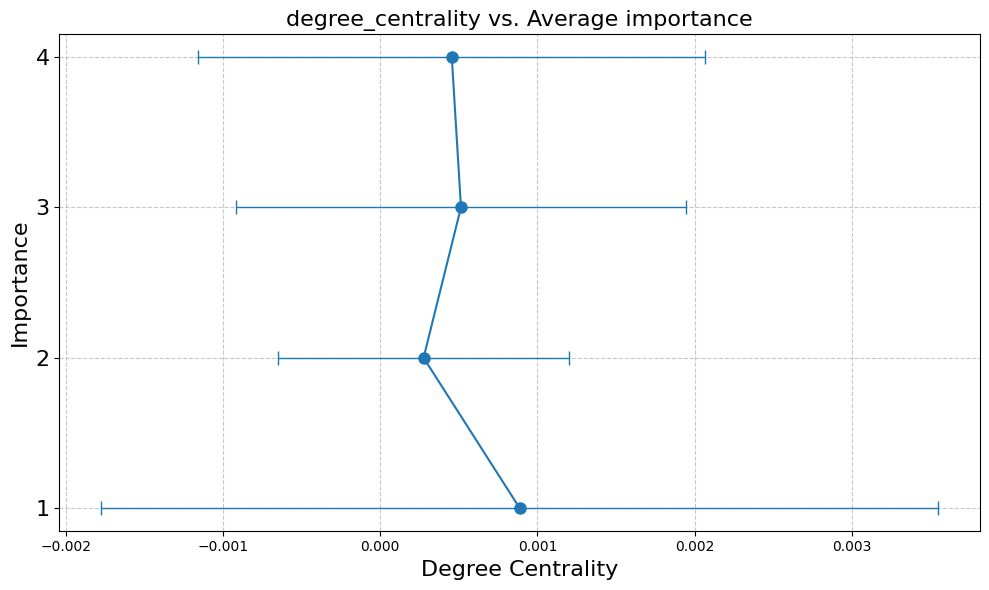

In [347]:
# Test
# UNBALANCED
network_results = {}
networks = load_networks('networks/balanced-importance')

# Analyze Networks
for network_name, data in networks.items():
    print(f"\nAnalyzing network: {network_name}")
    results = analyze_network(
        nodes_df=data['nodes'],
        edges_df=data['edges'],
        ground_truths=GROUND_TRUTHS,
        centralities=CENTRALITIES,
        composite_functions=['weight_composite_ranking', 'threshold_composite_ranking'],
        output_path=f'results/test/{network_name}'
    )
    network_results[network_name] = results

# Before comparison
if not network_results:
    raise ValueError("No networks were successfully analyzed. Check if data/split directory contains valid network data.")


# Compare results across networks
analysis = compare_networks(network_results, 'results/test/comparisons')

# Visualize results
visualize_network_commonalities(analysis, 'results/test/comparisons')

In [ ]:
# Analyse whole networks (balanced and unbalanced)
network_results = {}

networks = load_networks('networks/full-balanced-importance')
networks.update(load_networks('networks/full-unbalanced'))
networks.update(load_networks('networks/full-balanced-doctypebranch'))

# Analyze Networks
for network_name, data in networks.items():
    print(f"\nAnalyzing network: {network_name}")
    results = analyze_network(
        nodes_df=data['nodes'],
        edges_df=data['edges'],
        ground_truths=GROUND_TRUTHS,
        centralities=CENTRALITIES,
        composite_functions=['weight_composite_ranking',],
        output_path=f'results/full/{network_name}'
    )
    network_results[network_name] = results



# Before comparison
if not network_results:
    raise ValueError("No networks were successfully analyzed. Check if data/split directory contains valid network data.")


# Compare results across networks
analysis = compare_networks(network_results, 'results/full/comparisons')

# Visualize results
visualize_network_commonalities(analysis, 'results/full/comparisons')




# ANALYSE SPLIT NETWORKS
# UNBALANCED
network_results = {}
networks = load_networks('networks/unbalanced')

# Analyze Networks
for network_name, data in networks.items():
    print(f"\nAnalyzing network: {network_name}")
    results = analyze_network(
        nodes_df=data['nodes'],
        edges_df=data['edges'],
        ground_truths=GROUND_TRUTHS,
        centralities=CENTRALITIES,
        composite_functions=['weight_composite_ranking',],
        output_path=f'results/unbalanced/{network_name}'
    )
    network_results[network_name] = results

# Before comparison
if not network_results:
    raise ValueError("No networks were successfully analyzed. Check if data/split directory contains valid network data.")


# Compare results across networks
analysis = compare_networks(network_results, 'results/unbalanced/comparisons')

# Visualize results
visualize_network_commonalities(analysis, 'results/unbalanced/comparisons')



# BALANCED BY IMPORRTANCE 
network_results = {}
networks = load_networks('networks/balanced-importance')

# Analyze Networks
for network_name, data in networks.items():
    print(f"\nAnalyzing network: {network_name}")
    results = analyze_network(
        nodes_df=data['nodes'],
        edges_df=data['edges'],
        ground_truths=GROUND_TRUTHS,
        centralities=CENTRALITIES,
        composite_functions=['weight_composite_ranking',],
        output_path=f'results/balanced-importance/{network_name}'
    )
    network_results[network_name] = results

# Before comparison
if not network_results:
    raise ValueError("No networks were successfully analyzed. Check if data/split directory contains valid network data.")


# Compare results across networks
analysis = compare_networks(network_results, 'results/balanced-importance/comparisons')

# Visualize results
visualize_network_commonalities(analysis, 'results/balanced-importance/comparisons')



# BALANCED BY DOCTYPEBRANCH
network_results = {}
networks = load_networks('networks/balanced-doctypebranch')

# Analyze Networks
for network_name, data in networks.items():
    print(f"\nAnalyzing network: {network_name}")
    results = analyze_network(
        nodes_df=data['nodes'],
        edges_df=data['edges'],
        ground_truths=GROUND_TRUTHS,
        centralities=CENTRALITIES,
        composite_functions=['weight_composite_ranking',],
        output_path=f'results/balanced-doctypebranch/{network_name}'
    )
    network_results[network_name] = results

# Before comparison
if not network_results:
    raise ValueError("No networks were successfully analyzed. Check if data/split directory contains valid network data.")


# Compare results across networks
analysis = compare_networks(network_results, 'results/balanced-doctypebranch/comparisons')

# Visualize results
visualize_network_commonalities(analysis, 'results/balanced-doctypebranch/comparisons')